In [1]:
import pandas as pd
import numpy as np
import altair as alt
from matplotlib import pyplot as plt
import re
import string
import unicodedata
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist
import spacy
from spacy.lang.en.examples import sentences 
from sklearn.model_selection import train_test_split
from keras import Input
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras import Sequential
from keras.layers import TextVectorization, GRU, Bidirectional, Embedding, Dense, Dropout, RNN, LSTM
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
from keras.metrics import AUC, Recall
from tensorflow.keras.optimizers.legacy import Adam
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from keras.optimizers import SGD

## Problem and Data

This challenge on Kaggle is a Natural Language Processing (NLP) problem analyzing the text in tweets from Twitter. This analysis involves a binary classification to determine if a tweet is pertaining to a disaster (or an emergency) or not. For the challenge, data were provided as csv files and were split to training data, test data, and a sample submission was presented. 

In the training data there were the columns: id, text, location, keyword, and target. In the test data there were the columns: id, text, location, and keyword. The overall shape of the training data is (7613, 5) and the shape of the test data is (3263, 4). 


In [2]:
#import train
train = pd.read_csv('train.csv')
#import test
test = pd.read_csv('test.csv')
#import sample submission
samp = pd.read_csv('sample_submission.csv')

In [3]:
#shape of data
print('Train shape: ' + str(train.shape))
print('Test shape: ' + str(test.shape))

Train shape: (7613, 5)
Test shape: (3263, 4)


## EDA

By looking at the info of the data, I saw that there were NaN's placed in both the keyword and location columns for both the training and the test data. As I utilized both columns in my modeling, I decided to convert the NaN into a '' so the NLP would not be affected. It is of note that there were no NaN's in the text column of either data frame. 

Then, I utilized altair to chart the number of rows per class in the training data. This was followed up by charts illustrating the number of null values for both location and keyword columns with training data. After this, I added values for keywords at the beginning of each text value. Further, I added each location value at the end of each text value for both train and test values.

After this, I set X to be the training text column and y to be the training target column. Additionally X_test was set to test text option.

Further, I used LabelEncoder on the y labels so as to prepare for modelling.

In [4]:
#EDA
print('train:')
print(train.info())
print('\n')
print('test:')
print(test.info())

train:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


test:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None


In [5]:
#Converting Nas to ''
train = train.replace(np.nan, '', regex=True)
test = test.replace(np.nan, '', regex=True)

In [6]:
print('train:')
print(train.head())
print('\n')
print('test:')
print(test.head())

train:
   id keyword location                                               text  \
0   1                   Our Deeds are the Reason of this #earthquake M...   
1   4                              Forest fire near La Ronge Sask. Canada   
2   5                   All residents asked to 'shelter in place' are ...   
3   6                   13,000 people receive #wildfires evacuation or...   
4   7                   Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


test:
   id keyword location                                               text
0   0                                  Just happened a terrible car crash
1   2                   Heard about #earthquake is different cities, s...
2   3                   there is a forest fire at spot pond, geese are...
3   9                            Apocalypse lighting. #Spokane #wildfires
4  11                       Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
#Instances By Class
instance = alt.Chart(train).mark_bar().encode(
    alt.X('target:N', title = 'Classes'),
    alt.Y('count()', title = 'Number of Tweets'),
    color = alt.Color('target:N')
).properties(title = 'Number of Tweets by Class')

#removing limit of 5000 rows in altair chart
alt.data_transformers.disable_max_rows()
#showing chart
instance

alt.Chart(...)

In [8]:
#Plotting nulls for keyword and location by class --train
key_null_train = train[train['keyword'] == '']
location_null_train = train[train['location'] == '']
key = alt.Chart(key_null_train).mark_bar().encode(
    alt.X('target:N', title = 'Classes'),
    alt.Y('count()', title = 'Count of Nulls'),
    color = alt.Color('target:N')
).properties(title = 'Number of Null Keywords by Class in Train').interactive()
location = alt.Chart(location_null_train).mark_bar().encode(
    alt.X('target:N', title = 'Classes'),
    alt.Y('count()', title = 'Count of Nulls'),
    color = alt.Color('target:N')
).properties(title = 'Number of Null Locations by Class in Train').interactive()
key | location

alt.HConcatChart(...)

In [9]:
##Adding location and keyword to text data

#keyword
# train['keyword'] = train['keyword'].fillna('')
train['text'] = train['keyword'] + ' ' + train['text']
#keyword test
# test['keyword'] = test['keyword'].fillna('')
test['text'] = test['keyword'] + ' ' + test['text']

#location
train['location'] = train['location'].fillna('')
train['text'] = train['text'] + ' ' + train['location']

#location test
test['location'] = test['location'].fillna('')
test['location'] = test['text'] + ' ' + test['location']

In [10]:
#setting X and y
X = train['text']
y = train['target'].values
# getting y ready for modelling
le = LabelEncoder()
y = le.fit_transform(y)

#setting X_test
X_test = test['text']

## NLP Preprocessing

When performing NLP, the text needs to be preprocessed to improve training performance. As an example consider three variations of an English word: 'thoughtfulness', 'thôüghtfulnéss', and <thoughtfulness/>. While an English speaker will likely be able to understand the word at hand in each of these three variations, the first is the simplest as it is the typical spelling and does not require any extra steps for comprehension besides basic reading. A machine learning model or neural network will operate in much the same way. It derives meaning from the word and even further at the root of the word i.e. 'thoughtfullness' has meaning from 'thoughtful' and then even at the term 'thought.' 

Thus, I began to clean the words to their useful form. To do this, I borrowed upon a past NLP project I had completed, but also as a refresher utilized the article listed below. Functions were created and applied to the text in both training and test dataset so in order to: remove urls, remove punctuation, remove accents on characters, remove html markings, and to make every character lower case.

Then, I utilized the nltk and spacy packages to remove stopwords from the tweets. Stopwords are words such as 'an', 'a', 'or', 'that' which are quite common in the English language but which provide little semantic meaning. Given the low meaning associated with these words, they are removed so the model can focus on more meaningful content. NLTK and spacy each have their own list of English stopwords and I removed words from tweets that were in either list. 

Lastly, I lemmatized each word in every tweet. Lemmatizing is the process of using contextual analsyis of words to remove endings of words and return the lemma of a word or its root, base meaning. For example, consider the word 'saw.' If it were used as a noun (the tool) then the lemma of 'saw' would remain 'saw' as there is no base of the word which still captures its meaning. However, if 'saw' were utilized as a verb, then its lemma would become 'see' as at its core, 'saw' is a form of 'see' and this captures its base meaning. Here we can see lemmatizing can return differing values depending on the context a word is used in. Hence, this can be more powerful than stemming and is why I chose to utilize it. Further, the process itself helps the model in its performance as the model can still learn contextual meaning without having to deal with certain ends of words and overall reduce the vocabulary.

Also, I plotted the 25 most frequent words for both training and test data utilizing nltk FrequencyDistribution.

Data preprocessing source: https://towardsdatascience.com/nlp-preprocessing-with-nltk-3c04ee00edc0

Lemmatizing source: https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html

In [11]:
##Data Preprocessing with NLTK and spacy
#removing urls
def remove_url(val):
    return re.sub(r'https?://(www\.)?(\w+)(\.\w+)(/\w*)?', '', val)
def remove_punc(val):
    return ''.join([x for x in val if x not in string.punctuation])
def remove_accents(val):
    return unicodedata.normalize('NFKD', val).encode('ascii', 'ignore').decode('utf-8', 'ignore')
def remove_html(val):
    return BeautifulSoup(val, 'lxml').get_text()
def lower(val):
    return val.lower()
stop_words = set(stopwords.words('english'))
def remove_stopwords(val):
    tokens = word_tokenize(val)
    tokens_no_stop = [i for i in tokens if i not in stop_words]
    return (' ').join(tokens_no_stop)
spacy_nlp = spacy.load('en_core_web_sm')
spacy_stop_words = spacy_nlp.Defaults.stop_words
def remove_spacy_stopwords(val):
    not_stop = [i for i in word_tokenize(val) if i not in spacy_stop_words]
    return (' ').join(not_stop)
def lemmatize_func(val):
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(i) for i in word_tokenize(val)]
    return (' '.join(lemmas))


#applying functions to X and X_test text
funcs = [remove_url, remove_punc, remove_accents, remove_html, lower, remove_stopwords, 
         remove_spacy_stopwords, lemmatize_func]

for i in range(len(funcs)):
    X = X.apply(funcs[i])
    X_test = X_test.apply(funcs[i])

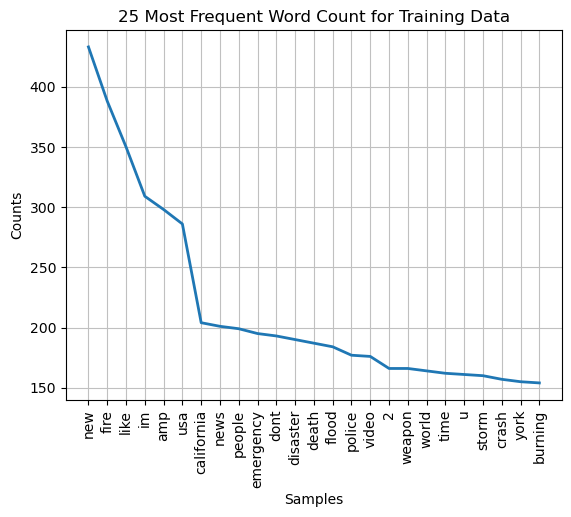

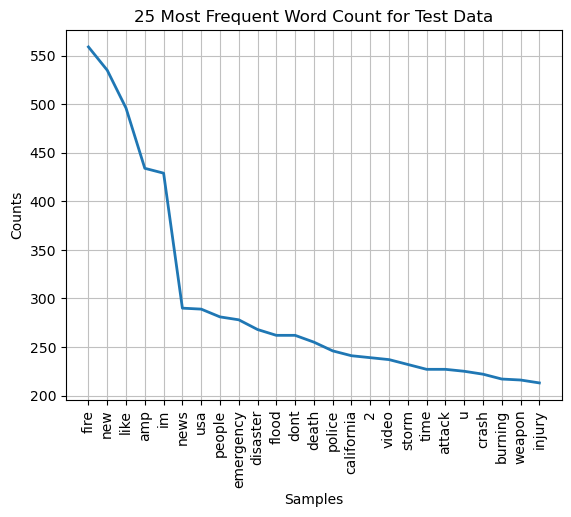

In [12]:
#plotting the most common words for training and text after data preprocessing
text = []
def most_frequent(df):
    def single_string(val):
        text.append(val)
    df.apply(single_string)

    words = ''
    for i in range(len(text)):
        for j in range(len(text[i])):
            if j == len(text[i]) - 1:
                words += text[i][j] + ' '
            else:
                words += text[i][j]


    frequency_distribution = FreqDist()
    for word in word_tokenize(words):
        frequency_distribution[word] += 1
    return frequency_distribution.plot(25, show = False)

#training data
most_frequent(X)
plt.title('25 Most Frequent Word Count for Training Data')
plt.show()
plt.clf()

#testing data
most_frequent(X_test)
plt.title('25 Most Frequent Word Count for Test Data')
plt.show()

## Vectorization and Tf dataset

Once we have completed data cleaning, we then need to vectorize data for input into our neural network. Vectorization is the idea of representing text as numerical vectors. These vectors are data that a neural network can understand and work with. Given the conversion from text to vector, the embedding is crucial to ensure each vector contains meaning similar to the word itself. 

In order to do this I utilized the tensorflow method TextVectorization. Here, I set the output mode for each value in the vectors to be integers. Then, the vectorizer was 'adapted' to the values in X. This means that the vectorizer utilized the vocabulary found in my cleaned text values in order to operate with. Then, once the vectorizer was built on the vocabulary, I created the numerical vectorized version of the training and test text.

After the word embedding (vectorization), the data needs to be prepared for input into the model. Building upon my second source below, I created a tf Dataset from the vectorized X and y values. Then, the dataset was shuffled for each iteration of the model so that the order of the data did not leak into the model. Further, I cached and prefetched the data so to improve moodel performance. This allows the gpu to load the data in parallel with the modeling. Finally, I separated the dataset into a training and validation set for modeling purposes.

Sources: 

https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization

https://www.tensorflow.org/guide/keras/preprocessing_layers



In [13]:
#Text Vectorization with tf text vectorization
vectorizer = TextVectorization(
    output_sequence_length = 200,
    output_mode = 'int'
)
vectorizer.adapt(X)
X_vectorized = vectorizer(X)
X_test_vectorized = vectorizer(X_test)

dataset = tf.data.Dataset.from_tensor_slices((X_vectorized, y))
batched_dataset = dataset.batch(8)
batched_dataset = batched_dataset.shuffle(buffer_size = 20000, reshuffle_each_iteration=True)
batched_dataset = batched_dataset.cache()
batched_dataset = batched_dataset.prefetch(16)
X_num, y_num = batched_dataset.as_numpy_iterator().next()
train = batched_dataset.take(int(len(batched_dataset) * 0.75))
valid = batched_dataset.skip(int(len(batched_dataset) * 0.75)).take(int(len(batched_dataset) * 0.25))

Metal device set to: Apple M2


2023-02-24 19:11:00.542813: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-24 19:11:00.543097: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-02-24 19:11:00.608221: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-24 19:11:00.670420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-24 19:11:00.995330: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the p

In [14]:
vocab_size = vectorizer.vocabulary_size()
vocab_size

18434

## Modeling

Utilizing keras, I then began to create a sequential model. I began by creating an embedding layer which randomly initializes weights to map the integers and their words to certain vectors. Through backpropagation, these embedding weights get trained so that similarities between words will be recognized.

I initially explored a LSTM layer for my RNN; however, based on lecture I decided to utilize a gated recurrent unit (GRU) layer. After exploring hyperparameter tuning, I eventually optimized at 64 units in the layer. Further, I made this GRU to be a part of a bidirectional layer. Based upon the third source below, this enables the model at any point x to train on data that came before x, but also to train on data upcoming in x. Additionally after this birdirectional GRU, I utilized two dense layers, both with relu activation and with 64 and 8 units, respectively. Finally, given the binary classification, I utilized a dense layer with 1 unit and sigmoid activation function.

After defining the layers, I then created a learning rate scheduler, which lowers exponentially each epoch after the first epoch. Then, I created an early stopper which starts after the 5th epoch (this was chosen given my initial high learning rate, so that the model can deepen as learning rate lowers through epochs). With these, it was time to compile the model and hear I chose the adam optimizer with an intital learning rate of 0.001 and the learning rate scheduler. Further, the model's loss was determined using binary crossentropy. Lastly, the metrics used in the model were accuracy and area under the ROC curve which is a measure of both the true postive rate and the false positive rate of the classifier.

Then, I fit the model over 15 epochs with a batch size of 8 and here using callbacks, early stopping and learning rate scheduler were utilized. This model was fitted with the history module so that visualizations of the model could be created. Here, I utilized pyplot to measure the accuracy on training and validation data as well as the loss on training and validation data. These visualizations do indicate that overfitting has occured. However, time did not permit for me to improve model performance past this level.



Source: https://www.tensorflow.org/text/tutorials/text_classification_rnn

https://www.tensorflow.org/text/guide/word_embeddings#:~:text=The%20Embedding%20layer%20takes%20the,batch%2C%20sequence%2C%20embedding)%20.

https://blog.paperspace.com/bidirectional-rnn-keras/

https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/

In [15]:
from keras.layers import BatchNormalization

In [59]:
#model
model = Sequential([
    Embedding(input_dim = vocab_size + 1, output_dim = 1028),
    Bidirectional(LSTM(256, activation = 'tanh')),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(8, activation = 'relu'),
    Dense(4, activation = 'relu'),
    Dense(1, activation='sigmoid')
])

#learning rate scheduler for improved speed
def scheduler(epoch, lr):
    if epoch < 1:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

#callback to run learning rate scheduler
learning = LearningRateScheduler(scheduler)

#callback for early stopping
callback = EarlyStopping()

#AUC
ROC = AUC()

#setting up adam optimizer
opt = Adam(
    learning_rate = 0.0001
)



#compiling the model
model.compile(
    optimizer = opt,
    loss='binary_crossentropy',
    metrics = ['accuracy', ROC]
)

In [60]:
history = model.fit(
    train, 
    validation_data = valid,
    epochs = 15, 
    batch_size = 8,
    callbacks=[learning, callback]
)

Epoch 1/15


2023-02-24 20:38:58.105023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-24 20:38:58.391876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-24 20:38:58.432657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-24 20:38:59.339255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-24 20:38:59.354040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


714/714 [==============================] - ETA: 0s - loss: 0.6411 - accuracy: 0.6292 - auc_17: 0.6550

2023-02-24 20:40:21.283856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-24 20:40:21.408467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-24 20:40:21.416916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


714/714 [==============================] - 95s 128ms/step - loss: 0.6411 - accuracy: 0.6292 - auc_17: 0.6550 - val_loss: 0.4870 - val_accuracy: 0.7799 - val_auc_17: 0.8348 - lr: 1.0000e-04
Epoch 2/15
714/714 [==============================] - 85s 119ms/step - loss: 0.3532 - accuracy: 0.8462 - auc_17: 0.9185 - val_loss: 0.4820 - val_accuracy: 0.7952 - val_auc_17: 0.8434 - lr: 9.0484e-05


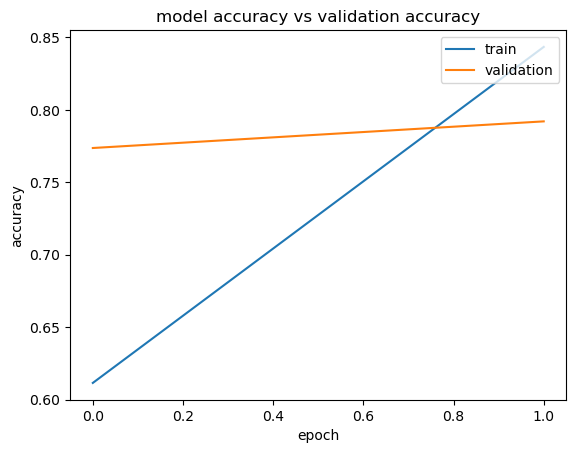

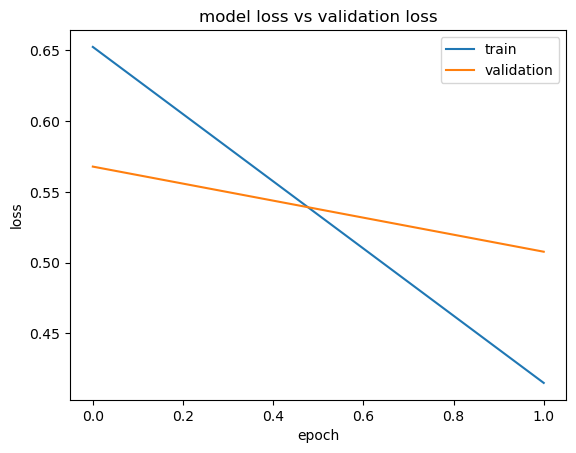

In [53]:
#accuracies chart
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()
#loss Chart
plt.clf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Prediction and Model Submission

In order to create predictions, each value in the vectorized X_test which altered the shape of the array for each vector in the data, so that the model could make predictions on it. Then, these were appended to a list and were transformed to a pd dataframe in the manner of the sample submission. Then, utilizing the kaggle package, the data was submitted to Kaggle.

In [61]:
#Vectorizing test data
# vectorized_test = vectorizer(X_test)

# predictions = model.predict(vectorized_test)
#do predictions for each vector in vectorized_test
predictions = []
for val in X_test_vectorized:
    predictions.append(model.predict(np.expand_dims(val, 0)))

2023-02-24 20:42:55.816244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-24 20:42:55.891158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-24 20:42:55.902710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step


In [62]:
#putting predictions into df mirroring sample submission and then submitting to Kaggle
submission_df = pd.DataFrame()
submission_df['id'] = test['id']
submission_df['target'] = predictions
submission_df['target'] = list(map(lambda x: 0 if x < 0.5 else 1, predictions))
submission_df.to_csv('sub.csv', index=False)


import kaggle
! chmod 600 /Users/sam/.kaggle/kaggle.json
! kaggle competitions submit -c nlp-getting-started -f sub.csv -m "LSTM bi-directional, early stopping, multiple dense"

100%|██████████████████████████████████████| 22.2k/22.2k [00:01<00:00, 18.9kB/s]
Successfully submitted to Natural Language Processing with Disaster Tweets

## Addendum TFIDF and Random Forest

Having utilized tfidf (term frequency inverse document frequency) in a prior nlp project, I decided to utilize it again here. Tfidf is the process of embedding words as numerical vectors by weighting the words according to their frequency in a document (as in standard word embedding I used above), however it also weighs it against the number of documents that contain each word against number of documents. Thus, the embedding of each word gives an overall better representation of each word. 

I performed numerous attempts to complete a tfidf and utilize it into my RNN, but I was never successful and due to time constraints I had to abandon this pursuit. Instead, I utilized a tfidf embedding and performed a random forest classifier on the data. Interestingly enough, this classifier was able to achieve an accuracy which rivaled the above neural net. The forest below achieved an accuracy of 0.79037 on the test data.

Source: https://github.com/skembr01/nlp_fetch_20newsgroups_project/blob/main/newsgroups_20.ipynb

In [63]:
##Trying tfidf again
vectorizer = TfidfVectorizer()
X_vector = vectorizer.fit_transform(X.values)
X_test_vector = vectorizer.transform(X_test)
X_train, X_valid, y_train, y_valid = train_test_split(X_vector, y, test_size = 0.2, random_state = 42)
X_train = X_train.toarray()
X_valid = X_valid.toarray()

In [64]:
clf = RandomForestClassifier(n_estimators=300, random_state=42, criterion = 'log_loss', bootstrap = True)
predict = clf.fit(X_train, y_train).predict(X_valid)
def mse(x, y):
    return np.mean((x - y) ** 2)
print('Mean squared error of validation:', mse(predict, y_valid))
from sklearn.metrics import accuracy_score
train_accuracy = clf.score(X_train, y_train)
test_accuracy = accuracy_score(y_valid, predict)
print('Training accuracy:', train_accuracy)
print('Test accuracy:', test_accuracy)
predictions_rf = clf.predict(X_test_vector)

Mean squared error of validation: 0.21470781352593565
Training accuracy: 0.9957307060755337
Test accuracy: 0.7852921864740644


In [ ]:
#putting predictions into df mirroring sample submission and then submitting to Kaggle
submission_df = pd.DataFrame()
submission_df['id'] = test['id']
submission_df['target'] = predictions_rf
# submission_df['target'] = list(map(lambda x: 0 if x < 0.5 else 1, predictions))
submission_df.to_csv('sub.csv', index=False)


import kaggle
! chmod 600 /Users/sam/.kaggle/kaggle.json
! kaggle competitions submit -c nlp-getting-started -f sub.csv -m "LSTM with dropout and compiling with recall also"

## Conclusion

In conclusion, this perhaps took me more time than is necessary for a mini-project. However, I did enjoy the project and it was very educational. We first learned the value of cleaning text and especially lemmatizing. Then, we learned the importance of word embedding. It was noteworthy that tfidf with random forest classifier achieved an accuracy nearly equivalent (or better) than a RNN with a classic count vectorizer. This could imply an improved NN architecture is needed (reasonable assertion) or that the tfidf word embedding just provides more context which adds to the value of NLP classification (also reasonable). Yet, regardless each model was able to achieve adequate performance for a mini-project of this nature, an accuracy of 0.79773.

Highest NN score: 0.79773

Highest tfidf RF score: 0.78669